# Rydberg Rabi oscillations
P. Huft

This notebook calculates the two-photon Rabi frequency and AC Stark shifts on each state in the ladder. 
Zeeman shifts to be added later.

In [1]:
from numpy import *
import numpy.random as rand
import numpy.linalg as la
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from simfuncs import *
from arc import *
from time import time
import os

#### local files
from physconsts import *
from rbconsts import *
from amophys import *


#### other
mpl.rcParams.update(mpl.rcParamsDefault)

### Rabi frequency

In [2]:
## calculate Rabi frequencies with experimental beam parameters
rb = Rubidium87()

# 780A
# P780 = 3.35e-6 # [W] light power at experiment cell
# a780 = 6e-6 # [m]
# b780 = 8e-6 # [m], in y direction
# A780 = a780*b780*pi # area at beam waist
# field780 = sqrt(2*P780/(c*e0*A780)) # the electric field amplitude
field780 = 3797.8949279380545 # calculated from Ramsey meas. in pol. calcs. about 92% of value gotten with beam size
delta780 = -2*pi*2.1e9 # [Hz] Single photon detuning

# 480
P480 = 0.9*0.014 # [W] light power at experiment cell
a480 = 4e-6 # [m]
b480 = 4e-6 # [m], in y direction
A480 = 1.3*a480*b480*pi # area at beam waist
field480 = sqrt(2*P480/(c*e0*A480)) # the electric field amplitude
delta480 = 2*pi*2.1e9 # [Hz] Single photon detuning

#                          hf_coupling(F,mF,J,q,FF,mFF,JJ,I:
O780A = float(abs(field780*hf_coupling(2,0,1/2,1,2,1,3/2,I)*D2_MatElem))/hbar

## hyperfine to fine structure state coupling, from Mark's notes section
# 8.4. Minho's thesis 2.4 has an error in the sixJ: j2 should be I. 
# this is specific to Rb87 because i use the hf 5p3/2 freqs from Steck, but could be generalized
# by using the hyperfine formula and the hyperfine constant for the atom of interest.

OmegaCommon = (field480*field780*D2_MatElem*rb.getReducedMatrixElementJ(5,1,3/2,84,2,5/2)*ee*a0
               /(2*delta480*hbar**2))

# required quantum numbers for ground, excited, Rydberg states
jg=1/2; fg=2; mfg=0;
ne=5; le=1; je=3/2;
jr=5/2; mjr=5/2;
q1 = q2 = 1 # photon projections

# single photon detuning from excited state c.o.m.
delta1 = -2*pi*(2.1e9 - 266.651e6)

little_c = lambda I,j,f,jj,ff: (-1)**(1+I+f+jj)*sqrt(2*f+1)*wigner_6j(j,I,f,ff,1,jj)

coupling_j_to_f = 0
for fr in j3_from_j1j2(I,jr):
    
    term = 0
    for fe in j3_from_j1j2(I,je):
        term += (little_c(I,jg,fg,je,fe)*little_c(I,je,fe,jr,fr)*
                 clebsch_gordan(fe,1,fr,mfg+q1,q2,mfg+q1+q2)*
                 clebsch_gordan(fg,1,fe,mfg,q1,mfg+q1)*
                 delta1/(delta1 - 2*pi*(hf_states[ne][le][je][fe] - 384230.48446856)))
    term *= clebsch_gordan(jr,I,fr,mjr,mfg+q1+q2-mjr,mfg+q1+q2)
    coupling_j_to_f += term
     
OmegaEff = float(OmegaCommon*coupling_j_to_f)

# now get Omega 480 from the OmegaEff and Omega 780
O480 = OmegaEff*2*delta480/O780A
assert O480*O780A/(2*delta480) - OmegaEff == 0, "rabi frequency calculation inconsistency"
print(f"780 Rabi frequency: 2pi*{float(O780A/(2*pi)):0.0f}")
print(f"480 Rabi frequency: 2pi*{float(O480/(2*pi)):0.0f}")
print(f"Single-photon detuning: 2pi*{float(delta480/(2*pi)):0.0f}")

print(f"effective two-photon Rabi frequency: 2pi*{float(OmegaEff/(2*pi)):0.0f}")

780 Rabi frequency: 2pi*102712885
480 Rabi frequency: 2pi*24538455
Single-photon detuning: 2pi*2100000000
effective two-photon Rabi frequency: 2pi*600099


In [166]:
pi*scl/Oeff

654.4984694978735

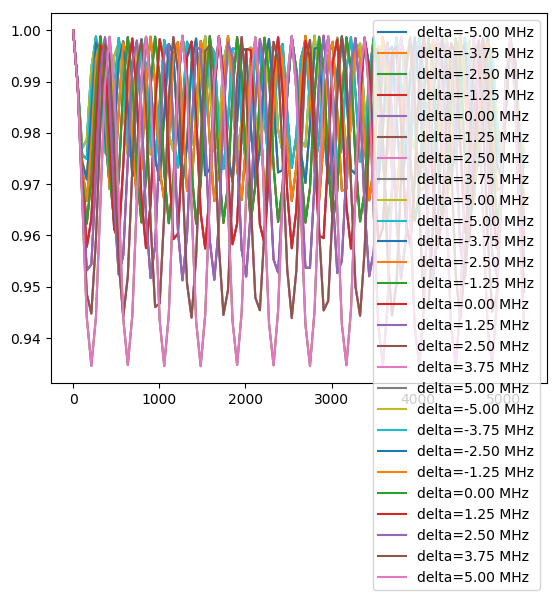

In [88]:
for s,l in zip(soln_list,detunings):
    plt.plot(s.t,real(conjugate(s.y[0])*s.y[0]),label=f"delta={l/1e6:.2f} MHz")
plt.legend(loc='best')
plt.show()

In [162]:
dU_ac_eg/(2*pi*1e6)

1.5011730573014075

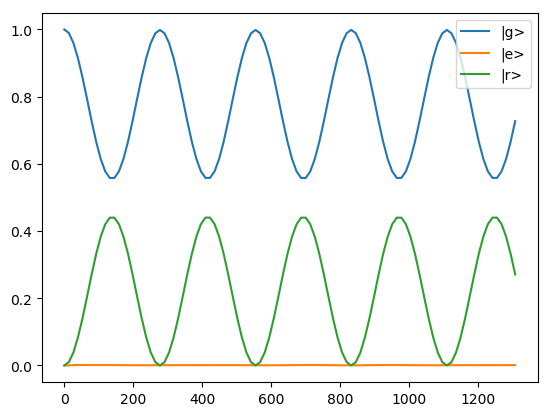

In [161]:
for s,l in zip(soln.y,['|g>','|e>','|r>']):
    plt.plot(soln.t,real(conjugate(s)*s),label=l)
plt.legend(loc='best')

In [164]:
detunings = linspace(-5e6,5e6,9)

## Rabi oscillations with RIN

In [14]:
## import actual RIN spectra
(f1,rin1), lbls1 = soln_from_csv(os.path.join('csv_analysis','soln_rin_780_20201223.csv'))

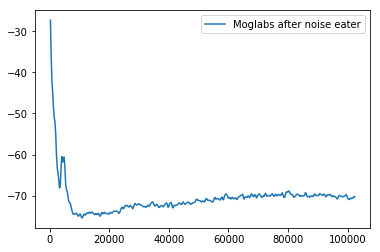

In [15]:
plt.plot(f1,real(rin1[1:]),label=lbls1[1])
# plt.plot(f,10*log10(x1[1:]/x1[0]), label=testlbls[1])
plt.legend()

In [22]:
## build time domain intensity function
int1 = lambda t: sum([sqrt(rin1[0]*10**(sx/10))*cos(2*pi*f*t+2*pi*rand.rand()) 
                      for f,sx in zip(f1,rin1[1:])]) # Fourier series

In [124]:
O780A,O480

(695214755.6324366, 71550273.89520717)

C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


(0, 1.3)

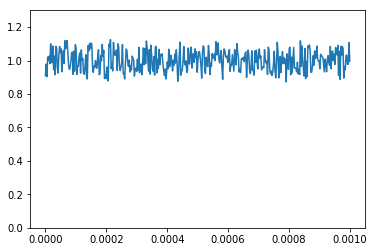

In [39]:
## time-domain intensity
fig,ax = plt.subplots()
# use enough time steps to resolve all frequency components
t_end = 0.001 # [s]
numpts = 4*int(t_end*max(f1))
t_steps = linspace(0,t_end,numpts)
int1_steps = real(array([int1(t)+rin1[0] for t in tsteps]))
int1_steps /= real(rin1[0]) # normalize to rin dc

ax.plot(tsteps, int1_steps)
ax.set_ylim((0,1.3))

In [79]:
## Rabi oscillation in two level atom
# the rabi frequency with noise is omega*(1+noise(t)) = omega*sqrt((dc + rin(t))/dc)

psi0 = array([1,0], complex) # population starts in |g>

delta = 0
omega = 2*pi*6e5 # the mean rabi frequency

# atom+field Hamiltonian, hbar=1
rabi = lambda t: omega*sqrt(real(int1(t)+rin1[0])/real(rin1[0]))
Haf = lambda t: array([[0,-rabi(t)/2],[-rabi(t)/2,delta]])
dpsi = lambda t,state: -1j*dot(Haf(t),state)

tmin = 0
tmax = 2*pi*10/omega
numpts = 4*int(t_end*max(f1))
tpts = linspace(tmin,tmax,numpts)

# get a average soln after multiple runs
avgs = 80
gsolns = empty((avgs,numpts),dtype=float)
for step in range(avgs):
    soln = solve_ivp(dpsi,[tmin,tmax],psi0,t_eval=tpts,vectorized=True)
    gsolns[step,:] = soln.y[0]

C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


(0, 1.3)

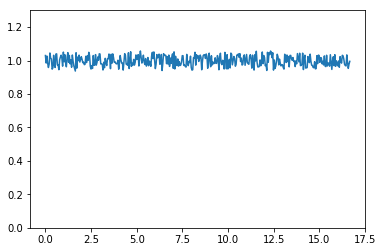

In [75]:
# the rabi frequency vs time
fig,ax = plt.subplots()
ax.plot(tpts/1e-6, [rabi(t)/omega for t in tpts])
ax.set_ylim((0,1.3))

In [89]:
Haf

array([[    0.        ,  -347.60737782,     0.        ],
       [ -347.60737782, 13194.68914508,   -35.77513695],
       [    0.        ,   -35.77513695,    -0.        ]])

In [80]:
avgsoln = sum(gsolns,axis=0)/avgs

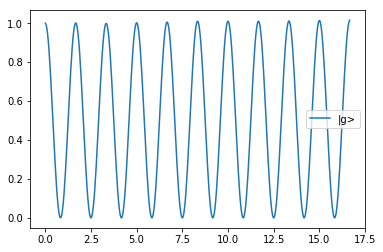

In [81]:
plt.plot(soln.t/1e-6,real(conjugate(avgsoln)*avgsoln),label='|g>')
plt.legend(loc='best')